In [1]:
#Import the libraries we'll need
import tensorflow as tf
import numpy as np
import matplotlib

import os
%matplotlib inline
matplotlib.rcParams.update({'font.size': 24})
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [2]:
#Functions to help extract the CIFAR-10 binary data
def unpickle(file):
    import cPickle
    with open(file, 'rb') as fo:
        dict = cPickle.load(fo)
    return dict

def extract_data(file):
    d = unpickle(file)
    dim = int(np.sqrt(d['data'].shape[1]/3))
    d['data'] = d['data'].reshape((-1,3,dim,dim))
    d['data'] = np.transpose(d['data'],axes=(0,2,3,1))
    return d['data'],np.array(d['labels'])

In [4]:
#Extract the data from binary files
directory = 'cifar-10-batches-py'
X = []
Y = []
for f in os.listdir(directory):
    if 'data_batch' in f:
        x,y = extract_data(directory+'/'+f)
        X.append(x)
        Y.append(y)
        
print 'found {} datasets'.format(len(X))
        
X_train = np.concatenate(X[:-1])
Y_train = np.concatenate(Y[:-1])

X_val = X[-1]
Y_val = Y[-1]

X_test, Y_test = extract_data(directory+'/test_batch')

print "X_train.shape = {}, Y_train.shape = {}".format(
    X_train.shape,Y_train.shape)

print "X_test.shape = {}, Y_test.shape = {}".format(
    X_test.shape,Y_test.shape)

classes = unpickle(directory+'/batches.meta')['label_names']
print classes

found 5 datasets
X_train.shape = (40000, 32, 32, 3), Y_train.shape = (40000,)
X_test.shape = (10000, 32, 32, 3), Y_test.shape = (10000,)
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


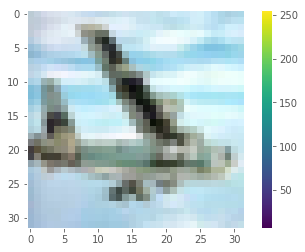

In [5]:
#Plot a random image so we can see what we are working with
i = np.random.randint(X_train.shape[0])
plt.figure()
plt.imshow(X_train[i,:,:,:])
plt.colorbar()
plt.grid('off')
plt.show()

In [6]:
#normalize the data
X_train = 1.0*X_train/255
X_val = 1.0*X_val/255
X_test = 1.0*X_test/255

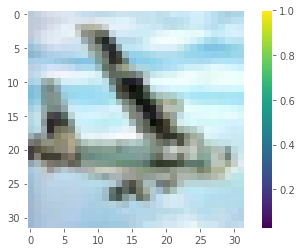

In [7]:
#Plot the same image to make sure the normalization worked
plt.figure()
plt.imshow(X_train[i,:,:,:])
plt.colorbar()
plt.grid('off')
plt.show()

In [8]:
#Define some Tensorflow convenience functions to help build the neural network
def conv2D(x, dims=[3,3], filters=32, strides=[1,1], 
           std=1e-3, padding='SAME', activation=tf.identity, scope='conv2d', reuse=False):
    
    with tf.variable_scope(scope,reuse=reuse):
        
        s = x.get_shape().as_list()
        shape = dims +[s[3],filters]
        
        W = tf.Variable(tf.random_normal(shape=shape,stddev=std),
            name='W')
        b = tf.Variable(tf.ones([filters])*std, name='b')
    
        o = tf.nn.convolution(x, W, padding, strides=strides)
        
        o = o+b
        
        a = activation(o)
        
        return a
    
def fullyConnected(x,output_units=100,activation=tf.identity,std=1e-3,
                  scope='fc',reuse=False):
    with tf.variable_scope(scope,reuse=reuse):
        
        s = x.get_shape().as_list()
        shape = [s[1],output_units]
        
        W = tf.Variable(tf.random_normal(shape, stddev=std))
        b = tf.Variable(tf.ones([shape[1]])*std)

        h = tf.matmul(x,W)+b
        a = activation(h)
        return a
    
def get_batch(X,Y,N,n=32):
    inds = np.random.choice(range(N),size=n, replace=False)
    x = X[inds]
    y = Y[inds]
    return x,y

In [9]:
#Define neural network and training parameters
train_steps = 15000
N = X_train.shape[0]
Nval = X_val.shape[0]
Nbatch = 32
print_step = 1000
W = X_train.shape[1]
H = W
C = 3
filters = 16
dims = [5,5]
pool_dims = [2,2]
strides = [1,1]
hidden_size = 100
act = tf.nn.relu
std=1e-2
num_classes=10
learning_rate=5e-3
momentum=0.9
l2_coeff = 0.0

In [10]:
#Tensorflow graph construction

#construct input place holders
x = tf.placeholder(shape=[None,W,H,C],dtype=tf.float32)
y = tf.placeholder(shape=[None],dtype=tf.int32)

o = conv2D(x,dims=dims,filters=filters,strides=strides,std=std,
           activation=act, scope='conv_1')

o = tf.nn.pool(o,pool_dims,'MAX',padding='VALID')

o = conv2D(o,dims=dims,filters=filters,strides=strides,std=std,
           activation=act, scope='conv_3')

o = tf.nn.pool(o,pool_dims,'MAX', padding='VALID')

s = o.get_shape().as_list()
o = tf.reshape(o,[-1,s[1]*s[2]*s[3]])

o = fullyConnected(o,hidden_size,scope='dense')

o = fullyConnected(o,num_classes,scope='fc_logits')

yhat = tf.nn.softmax(o)

loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=o,labels=y))

#Apply L2 regularization
var_list = tf.trainable_variables()

l2_reg = 0
for v in var_list:
    l2_reg += tf.reduce_mean(tf.square(v))
    
l2_reg = (1.0/len(var_list))*l2_coeff*l2_reg
loss = loss + l2_reg

In [11]:
#Construct the optimizer and training operations
opt = tf.train.MomentumOptimizer(learning_rate,momentum)
train = opt.minimize(loss)
init = tf.global_variables_initializer()

In [12]:
#Construct the tensorflow session and initialize the graph
sess = tf.Session()
sess.run(init)

In [13]:
#Start the train loop
train_hist = []
val_hist = []

for i in range(train_steps):
    xb,yb = get_batch(X_train,Y_train,N,n=Nbatch)
    l,_=sess.run([loss,train],{x:xb,y:yb})

    if i%print_step == 0:
        xb,yb = get_batch(X_val,Y_val,Nval,n=Nbatch)
        lval=sess.run(loss,{x:xb,y:yb})
        print "iter: {} Train: {}, Val: {}".format(i,l,lval)
        train_hist.append(l)
        val_hist.append(lval)

iter: 0 Train: 2.30258631706, Val: 2.30260324478
iter: 1000 Train: 2.30105447769, Val: 2.30803918839
iter: 2000 Train: 2.1596570015, Val: 1.81924152374
iter: 3000 Train: 1.20310425758, Val: 1.65782308578
iter: 4000 Train: 1.37457883358, Val: 1.28568506241
iter: 5000 Train: 1.23038744926, Val: 0.909376144409
iter: 6000 Train: 1.5028822422, Val: 1.46669220924
iter: 7000 Train: 1.22946357727, Val: 1.09290027618
iter: 8000 Train: 0.736906945705, Val: 1.14390778542
iter: 9000 Train: 1.0403470993, Val: 1.59702944756
iter: 10000 Train: 1.24430990219, Val: 0.987626135349
iter: 11000 Train: 0.734094500542, Val: 1.29921936989
iter: 12000 Train: 1.03050935268, Val: 0.961351752281
iter: 13000 Train: 0.652390778065, Val: 0.855452716351
iter: 14000 Train: 0.633599758148, Val: 1.29725909233


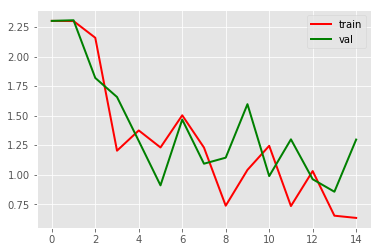

In [14]:
plt.figure()
plt.plot(train_hist, linewidth=2,color='r',label='train')
plt.plot(val_hist, linewidth=2,color='g',label='val')
plt.legend()
plt.show()

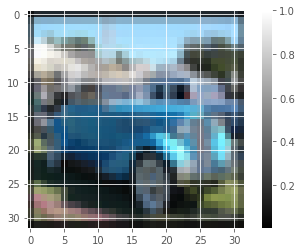

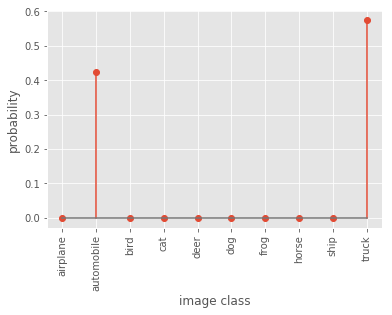

In [15]:
#Plot a random digit and the corresponding network output to see
#how well our network is working
index = np.random.randint(X_test.shape[0])
img = X_test[index,:]
plt.figure()
plt.imshow(img,cmap='gray')
plt.colorbar()
plt.savefig('probability_image.pdf',dpi=600)
plt.show()
plt.close()

#We need a batch dimension so we reshape the vector to (1,32,32,3)
input_vector = X_test[index,:]
input_vector = input_vector.reshape((1,32,32,3))
class_probabilities = sess.run(yhat,{x:input_vector})

plt.figure()
plt.stem(class_probabilities[0])
plt.xlabel('image class')
plt.ylabel('probability')
plt.xticks(np.arange(10),classes, rotation=90)
plt.savefig('probability.pdf',dpi=600)
plt.show()
plt.close()

Accuracy for class airplane = 56.5%
Accuracy for class automobile = 76.0%
Accuracy for class bird = 37.1%
Accuracy for class cat = 44.9%
Accuracy for class deer = 55.3%
Accuracy for class dog = 47.7%
Accuracy for class frog = 68.0%
Accuracy for class horse = 63.3%
Accuracy for class ship = 73.0%
Accuracy for class truck = 73.3%


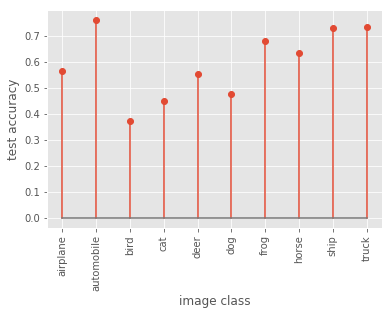

In [16]:
#calculate the accuracy for each class
N_test = X_test.shape[0]
predictions = []
for i in range(0,N,Nbatch):
    xb = X_test[i:i+Nbatch]
    predicted_probabilities = sess.run(yhat,{x:xb})
    predictions.append(predicted_probabilities)
predictions = np.concatenate(predictions)
predicted_classes = np.argmax(predictions,axis=1)

accuracies = []
for i in range(num_classes):
    class_indices = np.where(Y_test==i)[0]
    total_correct = np.sum(predicted_classes[class_indices]==Y_test[class_indices])
 
    acc = 1.0*total_correct/len(class_indices)
    accuracies.append(acc)
    print "Accuracy for class {} = {}%".format(classes[i],acc*100)
    
plt.figure()
plt.stem(accuracies)
plt.xlabel('image class')
plt.ylabel('test accuracy')
plt.xticks(np.arange(10),classes, rotation=90)
plt.savefig('accuracy.pdf',dpi=600)
plt.show()
plt.close()